# ProcessData

A notebook to process raw outputs of LDA runs (up to 10). It will process into results which can be used for analysis in this, and other, notebooks.
 
* ability to filter only stable topics for given threshold
* Process either decadal reports (science frontier panel chap 1-4) or Decadal Survey submitted whitepapers
* Choice of Spearman or Pearsons statistic
* Can knock out bad topics (or not)
* paragraph inference threshold

In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

sys.path.append("../src")
from process import *
from fitting_util import *
from plotting import *

import statistics as stat
from scipy.stats import sem

## Config Params

In [2]:
# set the version of the models/timeseries calc we want to examine

# Viz19, 10 Runs 125 topics, 'astro-only' high-impact journals, no SEDs
versions = ['19_2_125_rec1', '19_2_125_rec2','19_2_125_rec3','19_2_125_rec4','19_2_125_rec5',
            '19_2_125_rec6', '19_2_125_rec7','19_2_125_rec8','19_2_125_rec9','19_2_125_rec10'] 

# LPT to use for stable topics, available values -2.0, -2.5 and -5.0 (only rec1-rec5 however)
Lpt=-2.5 

# type of content to model
contentType = 'whitepapers' 
#contentType = 'decadal_report'

# version to plot
plot_version = versions[0] #'19_2_125_rec1'

# stable topic thresholds to examine
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# SED Topic (should be dropped, its a general process/format of data, not a research field per se)

# Gravity Wave topics, which are related to phenomena on earth, not the sky
ignore_topics = {'19_125_rec1': [],
                 '19_125_rec2': [],
                 '19_125_rec3': [],
                 '19_125_rec4': [],
                 '19_125_rec5': [],
                 '19_125_rec6': [],
                 '19_125_rec7': [],
                 '19_125_rec8': [],
                 '19_125_rec9': [],
                 '19_125_rec10': [],
                 '19_2_125_rec1': [65],
                 '19_2_125_rec2': [112],
                 '19_2_125_rec3': [41],
                 '19_2_125_rec4': [74],
                 '19_2_125_rec5': [5],
                 '19_2_125_rec6': [93],
                 '19_2_125_rec7': [112],
                 '19_2_125_rec8': [1],
                 '19_2_125_rec9': [6],
                 '19_2_125_rec10': [95]
                 }

# -------------------------------
# which cagr statistic to use
which_cagr = 'CAGR' #'CAGR' #'CAGR_2_year_rolling_mean' # 'CAGR_model_best_fit' 'CAGR'
#which_cagr = 'CAGR_2_year_rolling_mean' 
#which_cagr = 'CAGR_model_best_fit' 

flex_min_cagr = False # IF True, then min_cagr value is ignored in favor of using the minimum cagr
                      # within the given dataset run
min_cagr = -0.05 #-0.041 # for calculation of ri, the minimum cagr we expect to have to handle

# ignore inferences in paragraphs below this value
paragraph_inference_threshold = 0.0 # 0.01 # 0.1 # 1./125 

# use spearman coorelation coefficient instead of pearson
use_spearman = False

# minimum score_sum (of top topic inference). IF below, then we discard
# the result
#min_top_topic_score_sum = 0.8 # 0.5 == 50%;  ie, must be above X%
#min_top_topic_score_sum = 0.0 # This has no beneficial effect, see slides from 1-4-2021  # PARAM no longer used

# this is used to normalize the (TCS) score we get. It should be the value of 
# inference if all paragraphs/unit/etc embody only a single topic
document_max_score = {'decadal_report': 1009, 'whitepapers' : 274 }

# These values from Bootstrap Error estimation (see respective notebooks)
# TCS Literature (1998-2010) error (see Bootstrap_Estimation_1998-2010_TCS notebook)
tcs_lit_mean_err = 18.3

# TCS_CAGR error (see CAGR_Bootstrap_Estimation notebook)
cagr_mean_err = 0.004

# RI mean error (see RI_Bootstrap_Estimation notebook)
ri_mean_err = 1.3

## Notebook code

In [3]:
def has_ignore_topics (ig_dict:dict)->bool:
    for v in ig_dict.values():
        if len(v) > 0:
            return True
    return False

filtered = "_filtered" if has_ignore_topics(ignore_topics) else ""
print(filtered)

_filtered


In [4]:

def process_tdata(version:str, contentType:str, lda_viz_data:pd.DataFrame, timeseries_data:pd.DataFrame, topic_distrib_data:pd.DataFrame, ignore_topics:list=[]):
    
    # create dataset of summed inference in Panel reports vs CAGR
    # we need to carefully calculate the score. 
    # Hueristic: use only paragraphs where the top 5 topics sum to 0.5 or greater; 

    # process document inference data to get TCS score
    doc_tcs = doc_tcs_by_topic (topic_distrib_data, threshold=paragraph_inference_threshold)

    # now filter out topics which are 'unsuitable'
    # then create scatter plot of summed inference in document vs CAGR
    return create_dataset(doc_tcs, timeseries_data, lda_viz_data, which_cagr, ignore_topics, flex_min_cagr=flex_min_cagr,
                          min_cagr=min_cagr, max_doc_score=document_max_score[contentType])

## Pipeline Code

In [5]:
def doc_tcs_r(df:pd.DataFrame, param:str="ri", spearman:bool=False)->list:
    
    x=np.array(df['doc_tcs'])
    y=np.array(df[param])
    
    # coeff, p 
    if spearman:
        return scipy.stats.spearmanr(x, y)
    else:
        return scipy.stats.pearsonr(x, y)
    
def filter_stable_only(data:pd.DataFrame, threshold:float):
        if threshold == 0:
            return data
        else:
            # do stable topics
            str_topics = stable_topics[stable_topics['threshold']==threshold]
            str_topics = str_topics['topics'].to_list()[0]
            str_topics = str_topics[1:]
            str_topics = str_topics[:-1]       
            stable_topics_to_use = str_topics.split(',')

            # create dataset w/ only stable topics
            filt = [v.strip() for v in stable_topics_to_use]
            return data[data['topic'].isin(filt)]


## Run Pipeline

In [6]:
# pull it all together and run it
results = {v:{t:{} for t in thresholds} for v in versions}
for version in versions:
    
    # open basic files
    lda_viz_data, timeseries_data, topic_distrib_data, stable_topics = open_datafiles(version, lpt=Lpt, contentType=contentType)
    
    # process 
    data = process_tdata(version, contentType, lda_viz_data, timeseries_data, topic_distrib_data, ignore_topics[version])
    
    #save data
    if (contentType == 'decadal_report'):
        filename = f'../results/decadal_topic_data_{version}{filtered}.csv'
    elif (contentType == 'whitepapers'):
        filename = f'../results/whitepaper_topic_data_{version}{filtered}.csv'
    else:
        raise (f"Dont understand contenttype: {contentType}")
    
    print (f"wrote: {filename}") # old filename write for consistency
    data.to_csv(filename, index=False)
    
    # save this 
    data.to_csv(f'../results/{contentType}_results_{version}{filtered}.csv', index=False)
    
    for threshold in thresholds:
        data = filter_stable_only(data, threshold) 
        
        for param in ['tcs', 'cagr', 'ri']:
            coeff, p = doc_tcs_r(data, param, spearman=use_spearman) # get the correlation w/ document TCS (depends on contentType)
            results[version][threshold][param] = (coeff, p)

/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0220487315718552
wrote: ../results/whitepaper_topic_data_19_2_125_rec1_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0146265621035147
wrote: ../results/whitepaper_topic_data_19_2_125_rec2_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0400559166199228
wrote: ../results/whitepaper_topic_data_19_2_125_rec3_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.027918469495092
wrote: ../results/whitepaper_topic_data_19_2_125_rec4_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0274348726028328
wrote: ../results/whitepaper_topic_data_19_2_125_rec5_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0116199917219295
wrote: ../results/whitepaper_topic_data_19_2_125_rec6_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.015274148944639
wrote: ../results/whitepaper_topic_data_19_2_125_rec7_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0274359439434088
wrote: ../results/whitepaper_topic_data_19_2_125_rec8_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0242736932925894
wrote: ../results/whitepaper_topic_data_19_2_125_rec9_filtered.csv


/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0090295167033874
wrote: ../results/whitepaper_topic_data_19_2_125_rec10_filtered.csv


In [7]:
# create reports
print (f"inference thresh: {paragraph_inference_threshold} flex_min_cagr={flex_min_cagr}")
print (f" statistic: %s" % ('spearman' if use_spearman else 'pearson'))
if not flex_min_cagr:
    print (f"  fixed min_cagr={min_cagr}")
print (f"%s {contentType} @lp={Lpt} filtering: %s\n" % (versions[0][:-5], has_ignore_topics(ignore_topics)))

for param in ['tcs', 'cagr', 'ri']:
    
    coeff_vals = {t:[] for t in thresholds}
    p_vals = {t:[] for t in thresholds}

    # iterate over stable thresholds
    for t in thresholds:
        for vers in results.keys():
            coeff_vals[t].append(results[vers][t][param][0])
            p_vals[t].append(results[vers][t][param][1])

    print (f"\n Test of {param} vs doc_tcs:{contentType}")
    print (f"Threshold, Mean R, standard error, mean p")
    mean_correlations =[]
    mean_correlation_errs=[]
    for t in thresholds:
        m_corr = stat.mean(coeff_vals[t])
        m_corr_err = sem(coeff_vals[t])
        print (f"%3s %8.5f %8.5f %s" % (t, m_corr, m_corr_err, stat.mean(p_vals[t]) ))
        mean_correlations.append(m_corr)
        mean_correlation_errs.append(m_corr_err)

    #save data
    filename = f'../results/stable_topic_thresh_{param}_vs_{contentType}_{versions[0][:-5]}.csv'
    print (f"Writing: {filename}")
    st_data = pd.DataFrame({'mean_correlation': mean_correlations, 'mean_corr_stderr': mean_correlation_errs, 'min_stable_topic_threshold': thresholds})
    st_data.to_csv(filename, index=False)

inference thresh: 0.0 flex_min_cagr=False
 statistic: pearson
  fixed min_cagr=-0.05
19_2_125 whitepapers @lp=-2.5 filtering: True


 Test of tcs vs doc_tcs:whitepapers
Threshold, Mean R, standard error, mean p
  0  0.51210  0.01575 4.669898289233088e-08
0.1  0.51139  0.01553 4.654906971811139e-08
0.2  0.51143  0.01551 4.710281034098237e-08
0.3  0.50784  0.01552 5.9150785641603495e-08
0.4  0.50586  0.01776 3.0721388488014855e-06
0.5  0.51049  0.02488 0.00019438720609147157
0.6  0.51210  0.02900 0.002221990680299573
0.7  0.49930  0.02891 0.00896094845294621
0.8  0.50320  0.04538 0.07277532501516808
0.9  0.40945  0.07458 0.44322294353408814
Writing: ../results/stable_topic_thresh_tcs_vs_whitepapers_19_2_125.csv

 Test of cagr vs doc_tcs:whitepapers
Threshold, Mean R, standard error, mean p
  0  0.43310  0.01286 5.3695573705053885e-06
0.1  0.43304  0.01285 5.375949212225717e-06
0.2  0.43293  0.01287 5.418470538865114e-06
0.3  0.43812  0.01421 5.719630344827908e-06
0.4  0.44861  0.01534 2.

## Analysis of Results

(0.4, 0.75)

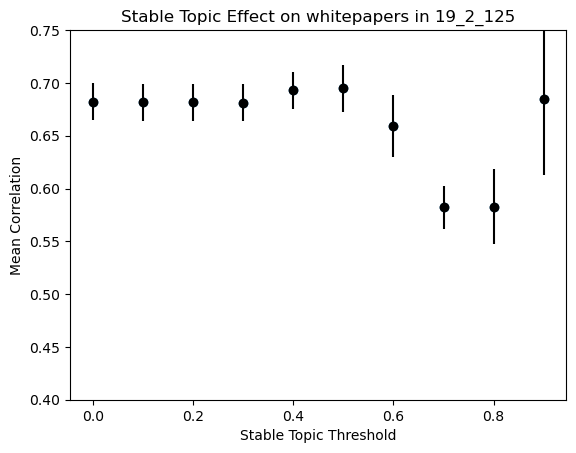

In [8]:
ax = plot_data_errs (thresholds, mean_correlations, mean_correlation_errs, ylabel="Mean Correlation", 
                     xlabel="Stable Topic Threshold", title=f"Stable Topic Effect on {contentType} in %s" % (versions[0][:-5]), ax=None)
ax.set_ylim([0.4, 0.75])

In [9]:
# Use this to examine if there is a threshold which is advantageous for improving results
#
if (False):
    print (f"Coeff and pvalues lp={Lpt} spearman={use_spearman}")
    for vers in versions:
        print (vers)
        for t in thresholds:
            for r in results[vers][t]:
                print(f"%3s %8.5f %12.10f" % (t, r[0], r[1]))


In [10]:
def plot_version_thresh(vers:str, thresh:float, contentType:str, spearman:bool=use_spearman):
    lda_viz_data, timeseries_data, topic_distrib_data, stable_topics = open_datafiles(vers, lpt=Lpt, contentType=contentType)
    
    # process 
    data = process_tdata(vers, contentType, lda_viz_data, timeseries_data, topic_distrib_data, ignore_topics[vers])
    data = filter_stable_only(data, thresh)    
    
    plot_report(data, title=f"{contentType} topics, model={version} thresh={thresh} lpt={Lpt}", 
                offset=-1*min_cagr, spearman=spearman, cagr_err=cagr_mean_err, ri_err=ri_mean_err, tcs_lit_err=tcs_lit_mean_err)

    return data

/home/jovyan/Code/ml_strat_prioritzation/notebooks/../src/process.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inf = float(row_data[t])


Data MIN_CAGR: -0.0116199917219295


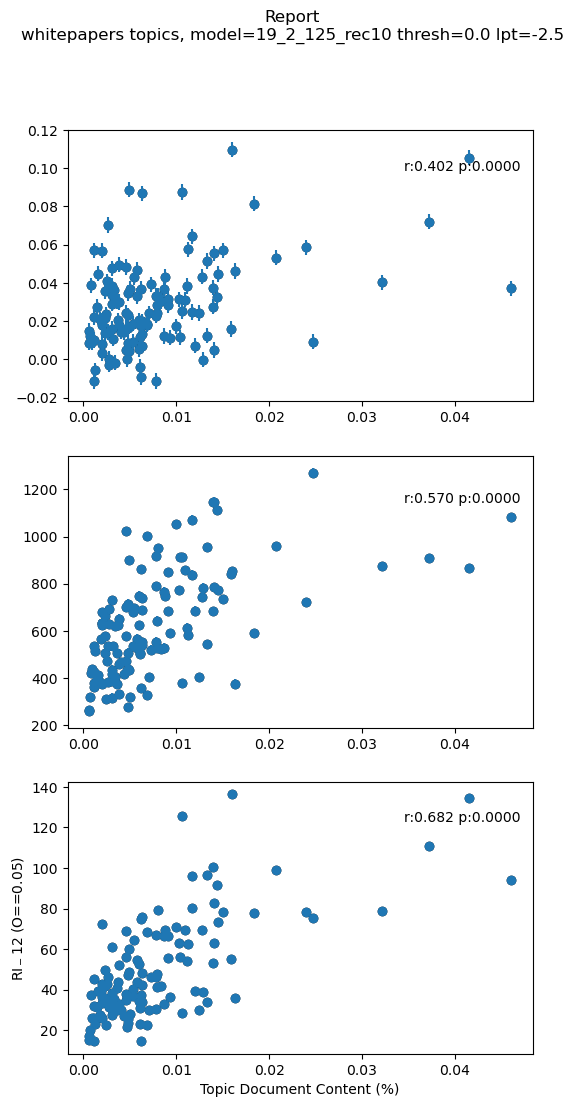

In [11]:
# plot some results for particular thresholds
threshold = 0.0
plot_version = '19_2_125_rec6'
data = plot_version_thresh(plot_version, threshold, contentType, spearman=use_spearman)

In [12]:
#data = plot_version_thresh(plot_version, 0.3, contentType)